# NLP Modeling

**Target Column 'subreddit' values:**

   - Cooking: 0
   - Keto: 1
   - EatCheapAndHealthy: 2
   - DIY: 3
   - DataScience: 4

In [630]:
#imports
import pandas as pd
import numpy as np
import time 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
import seaborn as sns

In [196]:
# read in data
data = pd.read_csv('./Data/5_reddit_clean_data.csv')
data.head()

,author,id,selftext,subreddit,title
0,YurkeyYacon,ewbxxh,If you make:\n\n1. A dish with some amount of ...,0,Does infusing oil make the herb flavor stronge...
1,truedef,ewbvum,Will a dutch baby in an enameled cast iron ves...,0,Dutch baby in enameled cast iron
2,Roupert2,ewbi6w,Mine is an 8 cup glass measuring cup. I had be...,0,What was your favorite kitchen purchase of 2019?
3,CholoFlakes,ewbdkh,I will cook dinner for my family tomorrow and ...,0,Best dishes to serve alongside some chili con ...
4,Tanstorm,ewba8g,"been having trouble with things sticking, kind...",0,Problem with stainless steel sticking Eggs or ...


In [200]:
# check the length of the dataframe
print(f'Shape: {data.shape}')
# find 10% of that
print(f'10% of that is {np.round(data.shape[0]*.1)} rows')

Shape: (61637, 5)
10% of that is 6164.0 rows


In [201]:
#check the subreddit proportions
data['subreddit'].value_counts(normalize = True)

1    0.233415
0    0.229700
2    0.208430
4    0.195191
3    0.133264
Name: subreddit, dtype: float64

The dataframe contains over 61,000 rows of reddit submissions. 10% will be partitioned off from the training and testing sets and held as validation set to use at the very end of this project. This will be done randomly with a random state so the data set is the same each time. 

In [202]:
# create a validation data set
validation_data = data.sample(6164, random_state=42)

In [203]:
# check the subreddit proportions to ensure they match the original
validation_data['subreddit'].value_counts(normalize=True)

0    0.232966
1    0.227125
2    0.213335
4    0.192408
3    0.134166
Name: subreddit, dtype: float64

In [204]:
# remove the validation set from the main data set
data.drop(index = validation_data.index, inplace= True)

In [205]:
# check to ensure change was applied
print('Data length: ',len(data))
print('Validation data length: ', len(validation_data))

Data length:  55473
Validation data length:  6164


### Split data to create a binomial data set with 'Datascience' and 'EatCheapAndHealthy' 

In [226]:
# create subset df with datascience and EatCheaplyAndHealthy subreddits called data_binomial => data_bi for short

data_bi = data[(data['subreddit'] == 2) | (data['subreddit'] == 4)]

In [234]:
# change EatCheapAndHealthy from 2 to 0 and datascience from 4 to 1
data_bi['subreddit'].replace(to_replace = (2,4), value = (0,1), inplace = True)

In [235]:
data_bi['subreddit'].value_counts()

0    11532
1    10845
Name: subreddit, dtype: int64

In [236]:
# set X and y
X = data_bi[['selftext','title']]
y = data_bi['subreddit']

In [237]:
#split data into train and test sets (no need to stratify, targets are balanced)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

Create Dataframe to store modeling results

In [288]:
#commented out to ensure the dataframe is not lost
#create a dataframe to store scores 
#score = pd.DataFrame(columns = ['data','vectorizer','model','hyperparameters','train_score','test_score', 'change',
                               'time_fit'])


In [569]:
#create function to save models used
def add_score(data, vectorizer, model, params, train_score, test_score, time_fit, subreddits, ID):
    print(f'{model} score added!')
    return  {'data': data,
            'vectorizer' : vectorizer,
            'model': model,
            'hyperparameters': params,
            'train_score': train_score,
            'test_score': test_score,
            'change': test_score - train_score,
            'time_fit': time_fit,
            'subreddits' :subreddits,
            'id' : ID
            }
    

### Run Binomial prediction models

#### Tfidf Vectorizer with Gausian Niave Bayes on 'title'

In [238]:
# create a class to wrap the TFIDF Vectorizer so that it returns dense arrays intead of sparse arrays
class DenseTfidfVectorizer(TfidfVectorizer):
    def transform(self, raw_documents, copy=True):
        X = super().transform(raw_documents, copy=copy)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        return df
    def fit_transform(self, raw_documents, y=None):
        X = super().fit_transform(raw_documents, y=y)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        return df
# code adapted from Stack Overflow, thanks swat

In [239]:
#Set up the pipeline for TFIDF Vectorizer with Gaussian NB
pipe = Pipeline([
                ('tfidf', DenseTfidfVectorizer(TfidfVectorizer())),
                ('gnb', GaussianNB())
])


#### Tune hyperparameters (multiple times)

In [318]:
params = {
    'tfidf__max_features' : [2000],
    'tfidf__stop_words' : ['english'],
    'tfidf__ngram_range' : [(1,1)],
    'tfidf__max_df' : [.70],
    }

In [319]:
# instantiate gridsearch on tfidf Vectorizer
gs = GridSearchCV(pipe,
                  params,
                  cv = 5)

In [320]:
# fit gridsearch
gs.fit(X_train['title'], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        DenseTfidfVectorizer(analyzer='word',
                                                             binary=False,
                                                             decode_error='strict',
                                                             dtype=<class 'numpy.float64'>,
                                                             encoding='utf-8',
                                                             input=TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                             

In [321]:
# check the best score and hyperperameters to achieve that score
print('Accuracy Score: ',gs.best_score_)
print('Best Hyperperameters: ', gs.best_params_) 

Accuracy Score:  0.9611488499582886
Best Hyperperameters:  {'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}


In [322]:
start = time.time()
gs_predictions = gs.predict(X_test['title'])
end = time.time()
time_fit = end-start

In [323]:
test_score = metrics.accuracy_score(y_test,gs_predictions)

In [324]:
# use the score function to add Gaussian NB to the df
score = score.append(add_score('Titles','TFIDF','Gaussian NB - CV5', gs.best_params_, 
                               gs.best_score_, test_score, time_fit),ignore_index=True,)

Gaussian NB - CV5 score added!


In [325]:
# check that the function worked
score.head()

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit
0,Titles,TFIDF,Gaussian NB,Defaults,0.934096,0.933870,-0.000227,1.578710
1,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.9, 'tfidf__max_features': ...",0.952926,0.949062,-0.003864,0.130855
2,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.237315
3,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.206991
4,Titles,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.961149,0.959249,-0.001900,0.209275


In [492]:
# create a TFIDF Gaussian DF so results can be stored
tfidf_gnb_results_titles = score.head()

In [493]:
#export results
tfidf_gnb_results_titles.to_csv('./results/tfidf_gnb_results_titles.csv')

#### Tfidf Vectorizer with Gausian Niave Bayes on 'selftext' or body of the post

In [380]:
# create new params for 'selftext'
params_2 = {
    'tfidf__max_features' : [5000],
    'tfidf__stop_words' : ['english'],
    'tfidf__ngram_range' : [(1,3)],
    'tfidf__max_df' : [.60],
    }

In [381]:
# instantiate gridsearch on tfidf Vectorizer
gs = GridSearchCV(pipe,
                  params_2,
                  cv = 5)

In [382]:
# fit gridsearch using 'selftext'
gs.fit(X_train['selftext'], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        DenseTfidfVectorizer(analyzer='word',
                                                             binary=False,
                                                             decode_error='strict',
                                                             dtype=<class 'numpy.float64'>,
                                                             encoding='utf-8',
                                                             input=TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                             

In [383]:
# check the best score and hyperperameters to achieve that score
print('Accuracy Score: ',gs.best_score_)
print('Best Hyperperameters: ', gs.best_params_) 

Accuracy Score:  0.9842688594923132
Best Hyperperameters:  {'tfidf__max_df': 0.6, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}


In [384]:
start = time.time()
gs_predictions = gs.predict(X_test['selftext'])
end = time.time()
time_fit = end-start

In [386]:
test_score = metrics.accuracy_score(y_test,gs_predictions)

In [387]:
# use the score function to add Gaussian NB to the df
score = score.append(add_score('Submissions','TFIDF','Gaussian NB - CV5', gs.best_params_, 
                               gs.best_score_, test_score, time_fit),ignore_index=True,)

Gaussian NB - CV5 score added!


In [388]:
score.head(10)

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit
0,Titles,TFIDF,Gaussian NB,Defaults,0.934096,0.933870,-0.000227,1.578710
1,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.9, 'tfidf__max_features': ...",0.952926,0.949062,-0.003864,0.130855
2,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.237315
3,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.206991
4,Titles,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.961149,0.959249,-0.001900,0.209275
5,Submissions,TFIDF,Gaussian NB - CV5,Defaults,0.952151,0.948704,-0.003447,5.435966
6,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.981766,0.979446,-0.002320,0.649771
7,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.149203
8,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.178886
9,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.984269,0.983557,-0.000712,1.438014


In [485]:
# create a TFIDF Gaussian on 'selftext' DF so results can be stored
tfidf_gnb_results_subs = score[(score['model'] == 'Gaussian NB - CV5') & (score['data'] == 'Submissions')]

In [494]:
#export results
tfidf_gnb_results_subs.to_csv('./results/tfidf_gnb_results_subs.csv')

#### Tfidf Vectorizer with Logistic Regression on 'title' 

In [406]:
#Set up the pipeline for TFIDF Vectorizer with Logistic Regression
pipe = Pipeline([
                ('tfidf', DenseTfidfVectorizer(TfidfVectorizer())),
                ('lr', LogisticRegression())
])

In [431]:
#set params
params = {
    'tfidf__max_features' : [2000],
    'tfidf__stop_words' : ['english'],
    'tfidf__ngram_range' : [(1,1)],
    'tfidf__max_df' : [.70],
    
    'lr__solver' : ['liblinear'],
    'lr__penalty' : ['l1','l2'],
    'lr__C' : [.1,.5,1]
    }

In [432]:
# instantiate gridsearch on tfidf Vectorizer and Logistic Regression
gs = GridSearchCV(pipe,
                  params,
                  cv = 5)

In [433]:
# fit gridsearch
gs.fit(X_train['title'], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        DenseTfidfVectorizer(analyzer='word',
                                                             binary=False,
                                                             decode_error='strict',
                                                             dtype=<class 'numpy.float64'>,
                                                             encoding='utf-8',
                                                             input=TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                             

In [434]:
# check the best score and hyperperameters to achieve that score
print('Accuracy Score: ',gs.best_score_)
print('Best Hyperperameters: ', gs.best_params_) 

Accuracy Score:  0.9684185436777499
Best Hyperperameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}


In [435]:
start = time.time()
gs_predictions = gs.predict(X_test['title'])
end = time.time()
time_fit = end-start

In [436]:
test_score = metrics.accuracy_score(y_test,gs_predictions)

In [437]:
# use the score function to add Logistic Regression to the df
score = score.append(add_score('Titles','TFIDF','Logistic - CV5', gs.best_params_, 
                               gs.best_score_, test_score, time_fit, 'datascience(1) & eat healthy(0)')
                               ,ignore_index=True,)

Logistic - CV5 score added!


In [440]:
# check the df scores
score[score['model'] == 'Logistic - CV5']

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit,subreddits
10,Titles,TFIDF,Logistic - CV5,Defaults,0.971696,0.971403,-0.000293,0.340591,datascience(1) & eat healthy(0)
11,Titles,TFIDF,Logistic - CV5,"{'lr__solver': 'lbfgs', 'tfidf__max_df': 0.7, ...",0.968419,0.966756,-0.001663,0.115476,datascience(1) & eat healthy(0)
12,Titles,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.968419,0.966756,-0.001663,0.115541,datascience(1) & eat healthy(0)


In [445]:
# create a TFIDF Logistic Regression DF so results can be stored
tfidf_lr_results_titles = score[score['model'] == 'Logistic - CV5']

In [495]:
#export results
tfidf_lr_results_titles.to_csv('./results/tfidf_lr_results_titles.csv')

#### Tfidf Vectorizer with Logistic Regression on 'selftext' or body of the post

In [472]:
params_2 = {
    'tfidf__max_features' : [2000],
    'tfidf__stop_words' : ['english'],
    'tfidf__ngram_range' : [(1,1)],
    'tfidf__max_df' : [.70],
    
     'lr__solver' : ['saga'],
    'lr__penalty' : ['l2'],
    'lr__C' : [1],
    }

In [473]:
# instantiate gridsearch on tfidf Vectorizer and Logistic Regression
gs = GridSearchCV(pipe,
                  params_2,
                  cv = 5)

In [474]:
# fit gridsearch
gs.fit(X_train['selftext'], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        DenseTfidfVectorizer(analyzer='word',
                                                             binary=False,
                                                             decode_error='strict',
                                                             dtype=<class 'numpy.float64'>,
                                                             encoding='utf-8',
                                                             input=TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                             

In [475]:
# check the best score and hyperperameters to achieve that score
print('Accuracy Score: ',gs.best_score_)
print('Best Hyperperameters: ', gs.best_params_)

Accuracy Score:  0.9869503038970325
Best Hyperperameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}


In [476]:
start = time.time()
gs_predictions = gs.predict(X_test['selftext'])
end = time.time()
time_fit = end-start

In [477]:
test_score = metrics.accuracy_score(y_test,gs_predictions)

In [478]:
# use the score function to add Logistic Regression to the df
score = score.append(add_score('Submissions','TFIDF','Logistic - CV5', gs.best_params_, 
                               gs.best_score_, test_score, time_fit, 'datascience(1) & eat healthy(0)')
                               ,ignore_index=True,)

Logistic - CV5 score added!


In [479]:
# check the df scores
score[score['model'] == 'Logistic - CV5'].head(10)

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit,subreddits
10,Titles,TFIDF,Logistic - CV5,Defaults,0.971696,0.971403,-0.000293,0.340591,datascience(1) & eat healthy(0)
11,Titles,TFIDF,Logistic - CV5,"{'lr__solver': 'lbfgs', 'tfidf__max_df': 0.7, ...",0.968419,0.966756,-0.001663,0.115476,datascience(1) & eat healthy(0)
12,Titles,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.968419,0.966756,-0.001663,0.115541,datascience(1) & eat healthy(0)
13,Submissions,TFIDF,Logistic - CV5,default,0.985818,0.983735,-0.002083,1.387176,datascience(1) & eat healthy(0)
14,Submissions,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.986950,0.983557,-0.003394,0.418481,datascience(1) & eat healthy(0)
15,Submissions,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.986950,0.983557,-0.003394,0.411237,datascience(1) & eat healthy(0)


In [480]:
# create a TFIDF Logistic Regression DF so results can be stored
tfidf_lr_results_subs = score[(score['model'] == 'Logistic - CV5') & (score['data'] == 'Submissions')]

In [496]:
#export results
tfidf_lr_results_subs.to_csv('./results/tfidf_lr_results_subs.csv')

In [534]:
# add id column to score df
count = 1
score['id'] = ''
for item in range(len(score)):
    score.loc[item,'id'] = count
    count += 1

In [536]:
score.head()

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit,subreddits,id
0,Titles,TFIDF,Gaussian NB,Defaults,0.934096,0.933870,-0.000227,1.578710,datascience(1) & eat healthy(0),1
1,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.9, 'tfidf__max_features': ...",0.952926,0.949062,-0.003864,0.130855,datascience(1) & eat healthy(0),2
2,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.237315,datascience(1) & eat healthy(0),3
3,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.206991,datascience(1) & eat healthy(0),4
4,Titles,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.961149,0.959249,-0.001900,0.209275,datascience(1) & eat healthy(0),5


### Run the best model against closely related subreddits, Cooking(0) and EatCheapAndHealthy(2)

In [498]:
# create subset df with Cooking and EatCheaplyAndHealthy subreddits called similar_binomial
similar_binomial = data[(data['subreddit'] == 0) | (data['subreddit'] == 2)]

In [500]:
# change EatCheapAndHealthy from 2 to 1 
similar_binomial['subreddit'].replace(to_replace = 2, value = 1, inplace = True)

In [501]:
similar_binomial['subreddit'].value_counts()

0    12722
1    11532
Name: subreddit, dtype: int64

In [554]:
# set X and y
X = similar_binomial[['selftext','title']]
y = similar_binomial['subreddit']

In [555]:
#split data into train and test sets (no need to stratify, targets are balanced)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

Select the best model

In [556]:
#sort on test score
score.sort_values(by=['test_score'],ascending=False)

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit,subreddits,id
13,Submissions,TFIDF,Logistic - CV5,default,0.985818,0.983735,-0.002083,1.387176,datascience(1) & eat healthy(0),14
7,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.149203,datascience(1) & eat healthy(0),8
8,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.178886,datascience(1) & eat healthy(0),9
9,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.984269,0.983557,-0.000712,1.438014,datascience(1) & eat healthy(0),10
14,Submissions,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.986950,0.983557,-0.003394,0.418481,datascience(1) & eat healthy(0),15
15,Submissions,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.986950,0.983557,-0.003394,0.411237,datascience(1) & eat healthy(0),16
6,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.981766,0.979446,-0.002320,0.649771,datascience(1) & eat healthy(0),7
10,Titles,TFIDF,Logistic - CV5,Defaults,0.971696,0.971403,-0.000293,0.340591,datascience(1) & eat healthy(0),11
11,Titles,TFIDF,Logistic - CV5,"{'lr__solver': 'lbfgs', 'tfidf__max_df': 0.7, ...",0.968419,0.966756,-0.001663,0.115476,datascience(1) & eat healthy(0),12
12,Titles,TFIDF,Logistic - CV5,"{'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver'...",0.968419,0.966756,-0.001663,0.115541,datascience(1) & eat healthy(0),13


In [557]:
# locate model #15 params
score['hyperparameters'].loc[15]

{'lr__C': 1,
 'lr__penalty': 'l2',
 'lr__solver': 'saga',
 'tfidf__max_df': 0.7,
 'tfidf__max_features': 2000,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

Best model selected for accuracy and speed: model id 15
- Run on: Submissions	
- Using TFIDF Vectorizer
- Logistic Regression - CV5	
- Params: {'lr__C': 1,
 'lr__penalty': 'l2',
 'lr__solver': 'saga',
 'tfidf__max_df': 0.7,
 'tfidf__max_features': 2000,
 'tfidf__ngram_range': (1, 1),
 'tfidf__stop_words': 'english'}

In [622]:
#Set up the pipeline for optimized TFIDF Vectorizer with Logistic Regression
pipe = Pipeline([
                ('tfidf', DenseTfidfVectorizer(TfidfVectorizer())),
                ('lr', LogisticRegression())
])

In [623]:
params = {
    'tfidf__max_features' : [2000],
    'tfidf__stop_words' : ['english'],
    'tfidf__ngram_range' : [(1,1)],
    'tfidf__max_df' : [.70],
    
     'lr__solver' : ['saga'],
    'lr__penalty' : ['l2'],
    'lr__C' : [1],
    }

In [624]:
# instantiate gridsearch on tfidf Vectorizer and Logistic Regression
gs = GridSearchCV(pipe,
                  params,
                  cv = 5)

In [626]:
# fit gridsearch
gs.fit(X_train['selftext'], y_train)

/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/scottrosengrants/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        DenseTfidfVectorizer(analyzer='word',
                                                             binary=False,
                                                             decode_error='strict',
                                                             dtype=<class 'numpy.float64'>,
                                                             encoding='utf-8',
                                                             input=TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                             

In [562]:
# check the best score and hyperperameters to achieve that score
print('Accuracy Score: ',gs.best_score_)
print('Best Hyperperameters: ', gs.best_params_)

Accuracy Score:  0.8321055525013744
Best Hyperperameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'saga', 'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}


In [627]:
start = time.time()
gs_predictions = gs.predict(X_test['selftext'])
end = time.time()
time_fit = end-start

In [628]:
test_score = metrics.accuracy_score(y_test,gs_predictions)

In [573]:
# use the score function to add Logistic Regression to the df
score = score.append(add_score('Submissions','TFIDF','Logistic - CV5', gs.best_params_, 
                               gs.best_score_, test_score, time_fit, 'cooking(0) & eat healthy(1)', 17.0)
                               ,ignore_index=True,)

Logistic - CV5 score added!


In [574]:
score.head(20)

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit,subreddits,id
0,Titles,TFIDF,Gaussian NB,Defaults,0.934096,0.933870,-0.000227,1.578710,datascience(1) & eat healthy(0),1.0
1,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.9, 'tfidf__max_features': ...",0.952926,0.949062,-0.003864,0.130855,datascience(1) & eat healthy(0),2.0
2,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.237315,datascience(1) & eat healthy(0),3.0
3,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.206991,datascience(1) & eat healthy(0),4.0
4,Titles,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.961149,0.959249,-0.001900,0.209275,datascience(1) & eat healthy(0),5.0
5,Submissions,TFIDF,Gaussian NB - CV5,Defaults,0.952151,0.948704,-0.003447,5.435966,datascience(1) & eat healthy(0),6.0
6,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.981766,0.979446,-0.002320,0.649771,datascience(1) & eat healthy(0),7.0
7,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.149203,datascience(1) & eat healthy(0),8.0
8,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.178886,datascience(1) & eat healthy(0),9.0
9,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.984269,0.983557,-0.000712,1.438014,datascience(1) & eat healthy(0),10.0


### Run multi-classification prediction models

#### Tfidf Vectorizer with Support Vector on 'title' with Datascience, EatCheapAndHealthy, Cooking, and Keto subreddits

**Target Column 'subreddit' values:**

   - Cooking: 0
   - Keto: 1
   - EatCheapAndHealthy: 2
   - DIY: 3
   - DataScience: 4

In [578]:
#use the full data set 'data' but reduce the row size (helps not overburden the SVM)
SVM_data = data.sample(20000, random_state=42)
# set X and y
X = SVM_data[['selftext','title']]
y = SVM_data['subreddit']

In [577]:
SVM_data['subreddit']

28682    2
50163    4
46088    3
18809    1
9956     0
        ..
28477    1
48912    3
29684    2
7219     0
55057    4
Name: subreddit, Length: 20000, dtype: int64

In [579]:
#split data into train and test sets (no need to stratify, targets are fairly balanced)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [580]:
#Set up the pipeline for TFIDF Vectorizer with SVM classifier
pipe = Pipeline([
                ('tfidf', DenseTfidfVectorizer(TfidfVectorizer())),
                ('svc', SVC())
])

In [581]:
# use the tfidf optimized parameters
params = {
    'tfidf__max_features' : [2000],
    'tfidf__stop_words' : ['english'],
    'tfidf__ngram_range' : [(1,1)],
    'tfidf__max_df' : [.70],
    
    'svc__gamma' : ['scale']
    }

In [582]:
# instantiate gridsearch on tfidf Vectorizer and SVM
gs = GridSearchCV(pipe,
                  params,
                  cv = 5)

In [583]:
# fit gridsearch on title data
gs.fit(X_train['title'], y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        DenseTfidfVectorizer(analyzer='word',
                                                             binary=False,
                                                             decode_error='strict',
                                                             dtype=<class 'numpy.float64'>,
                                                             encoding='utf-8',
                                                             input=TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.float64'>,
                             

In [584]:
# check the best score and hyperperameters to achieve that score
print('Accuracy Score: ',gs.best_score_)
print('Best Hyperperameters: ', gs.best_params_)

Accuracy Score:  0.7650666666666667
Best Hyperperameters:  {'svc__gamma': 'scale', 'tfidf__max_df': 0.7, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': 'english'}


In [585]:
start = time.time()
gs_predictions = gs.predict(X_test['selftext'])
end = time.time()
time_fit = end-start

In [586]:
# use the score function to add SVM to the df
score = score.append(add_score('Submissions','TFIDF','SVC - CV5', gs.best_params_, 
                               gs.best_score_, test_score, time_fit, 
                               'cooking(0), keto(1), eat healthy(2), DIY(3), datascience(4)', 18.0)
                               ,ignore_index=True,)

SVC - CV5 score added!


In [587]:
score.head(20)

,data,vectorizer,model,hyperparameters,train_score,test_score,change,time_fit,subreddits,id
0,Titles,TFIDF,Gaussian NB,Defaults,0.934096,0.933870,-0.000227,1.578710,datascience(1) & eat healthy(0),1.0
1,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.9, 'tfidf__max_features': ...",0.952926,0.949062,-0.003864,0.130855,datascience(1) & eat healthy(0),2.0
2,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.8, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.237315,datascience(1) & eat healthy(0),3.0
3,Titles,TFIDF,Gaussian NB,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.958765,0.959249,0.000484,0.206991,datascience(1) & eat healthy(0),4.0
4,Titles,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.961149,0.959249,-0.001900,0.209275,datascience(1) & eat healthy(0),5.0
5,Submissions,TFIDF,Gaussian NB - CV5,Defaults,0.952151,0.948704,-0.003447,5.435966,datascience(1) & eat healthy(0),6.0
6,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.981766,0.979446,-0.002320,0.649771,datascience(1) & eat healthy(0),7.0
7,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.7, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.149203,datascience(1) & eat healthy(0),8.0
8,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.983792,0.983557,-0.000235,1.178886,datascience(1) & eat healthy(0),9.0
9,Submissions,TFIDF,Gaussian NB - CV5,"{'tfidf__max_df': 0.6, 'tfidf__max_features': ...",0.984269,0.983557,-0.000712,1.438014,datascience(1) & eat healthy(0),10.0


In [607]:
# create confusion matrix
conf_matrix = pd.crosstab(y_test, gs_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

#code adapted from turdus-merula link: https://stats.stackexchange.com/questions/95209/how-can-i-interpret-sklearn-confusion-matrix


   - Cooking: 0
   - Keto: 1
   - EatCheapAndHealthy: 2
   - DIY: 3
   - DataScience: 4

In [608]:
#add column and row names
conf_matrix = conf_matrix.rename(columns = {0:'Cooking', 1:'Keto', 2:'Healthy', 3:'DIY', 4:'Data'},
                                index = {0:'Cooking', 1:'Keto', 2:'Healthy', 3:'DIY', 4:'Data'})

In [609]:
#view matrix
conf_matrix

Predicted,Cooking,Keto,Healthy,DIY,Data,All
True,,,,,,
Cooking,992,29,127,43,12,1203
Keto,66,944,88,7,3,1108
Healthy,275,62,705,4,8,1054
DIY,52,33,17,540,20,662
Data,15,34,2,14,908,973
All,1400,1102,939,608,951,5000


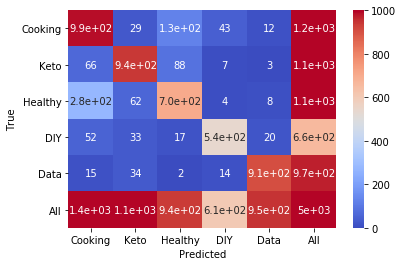

In [621]:
#plot the matrix in seaborn
sns.heatmap(conf_matrix, vmin = 0, vmax = 1000, cmap = 'coolwarm', annot = True)

In [638]:
#export all model scores
score.to_csv('./results/all_model_scores.csv')